In [7]:
import librosa
import tensorflow as tf
from tensorflow.keras import Model,Input,Sequential
from tensorflow.keras.layers import Conv1D,Conv2D,Conv3D,Flatten,MaxPool2D,Dense,Softmax,BatchNormalization
import librosa.display
import os
import pandas as pd
import numpy as np
from time import time 
import random as rd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import threading
from sklearn.metrics import confusion_matrix,accuracy_score

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

path_to_db_voice = "C:\\Users\\antoi\\Desktop\\Airbus\\projet_AIRBUS\\db\\voice\\"
path_to_db_plane = "C:\\Users\\antoi\\Desktop\\Airbus\\projet_AIRBUS\\db\\plane\\"
path_to_db_both = "C:\\Users\\antoi\\Desktop\\Airbus\\projet_AIRBUS\\db\\both\\"

l_voice_records = os.listdir(path_to_db_voice)
l_airplane_records = os.listdir(path_to_db_plane)
l_both_records = os.listdir(path_to_db_both)

In [8]:
def get_threshold_freq(f):
    i=0
    for elt in librosa.fft_frequencies(22050,2048):
        if elt >f:
            return i
        else:
            i+=1

get_threshold_freq(2000)

186

In [9]:
def separe_train_test(db_folder_path,n_records,test_size):
    l_records = os.listdir(db_folder_path)
    sub_l_records = rd.sample(l_records,n_records)
    size = len(sub_l_records)
    sep = round(test_size*size)
    sample = rd.sample(sub_l_records,size)
    test = sample[:sep]
    train = sample[sep:]
    return train,test

In [10]:
def gen_X_train_test(db_folder_path,n_records,test_size):
    sp_rec_train = []
    sp_rec_test = []
    records_train,records_test = separe_train_test(db_folder_path,n_records,test_size)
    i = 0
    for record in records_train:
        print('Building train {}/{}'.format(i,len(records_train)),end='\r')
        signal,sample_rate = librosa.load(db_folder_path + record)
        spectrum = librosa.stft(y=signal,center=True) 
        spectrum = spectrum.astype(float)
        if spectrum.shape[1]>=100:
            n_morceaux = spectrum.shape[1]//100 # pour avoir des pas de 2.3s
            sub_spectrums = [librosa.amplitude_to_db(spectrum[:,j*100:(j+1)*100]) for j in range(n_morceaux)]
            sp_rec_train += sub_spectrums
        i+=1
    i=0
    for record in records_test: 
        print('Building  test {}/{}'.format(i,len(records_test)),end='\r')
        signal,sample_rate = librosa.load(db_folder_path + record)
        spectrum = librosa.stft(y=signal,center=True) 
        spectrum = spectrum.astype(float)
        if spectrum.shape[1]>=100:
            n_morceaux = spectrum.shape[1]//100 # pour avoir des pas de 2.3s
            sub_spectrums = [librosa.amplitude_to_db(spectrum[:,j*100:(j+1)*100]) for j in range(n_morceaux)]
            sp_rec_test += sub_spectrums
            i+=1

    # sp_train = np.concatenate(sp_rec_train)
    # sp_test = np.concatenate(sp_rec_test)
    # print(sp_rec_train[0].shape)
    return np.array(sp_rec_train),np.array(sp_rec_test)

In [11]:
n_records = 178

X_voice_train,X_voice_test= gen_X_train_test(path_to_db_voice,n_records,0.2)
print('Voice done',end='\r')
X_plane_train,X_plane_test = gen_X_train_test(path_to_db_plane,n_records,0.2)
print('Plane done',end='\r')
X_both_train,X_both_test = gen_X_train_test(path_to_db_both,n_records,0.2)
print('Both done',end='\r')

In [12]:
only_voice = 1
only_plane = 0
both_classes = 1

y_voice_train = np.array([only_voice for elt in X_voice_train])
y_plane_train = np.array([only_plane for elt in X_plane_train])
y_both_train = np.array([both_classes for elt in X_both_train])

y_voice_test = np.array([only_voice for elt in X_voice_test] )
y_plane_test = np.array([only_plane for elt in X_plane_test])
y_both_test = np.array([both_classes for elt in X_both_test])

X_train = np.concatenate([X_voice_train , X_plane_train , X_both_train])
X_test = np.concatenate([X_plane_test , X_both_test])

y_train = np.concatenate([y_voice_train , y_plane_train , y_both_train])
y_test =np.concatenate([y_plane_test , y_both_test])

In [13]:
with open('npy/X_train_2.npy','wb') as f:
    np.save(f,X_train)

with open('npy/X_test_2.npy','wb') as f:
    np.save(f,X_test)

with open('npy/y_train_2.npy','wb') as f:
    np.save(f,y_train)

with open('npy/y_test_2.npy','wb') as f:
    np.save(f,y_test)

In [67]:
# only_voice = [0,1]
# only_plane = [1,0]
# both_classes = [1,1]

# y_voice_train = np.array([only_voice for elt in X_voice_train])
# y_plane_train = np.array([only_plane for elt in X_plane_train])
# y_both_train = np.array([both_classes for elt in X_both_train])

# y_voice_test = np.array([only_voice for elt in X_voice_test] )
# y_plane_test = np.array([only_plane for elt in X_plane_test])
# y_both_test = np.array([both_classes for elt in X_both_test])

# X_train = np.concatenate([X_voice_train , X_plane_train , X_both_train])
# X_test = np.concatenate([X_plane_train , X_both_train])

# y_train = np.concatenate([y_voice_train , y_plane_train , y_both_train])
# y_test =np.concatenate([y_plane_test , y_both_test])


# with open('npy/X_train.npy','wb') as f:
#     np.save(f,X_train)

# with open('npy/X_test.npy','wb') as f:
#     np.save(f,X_test)

# with open('npy/y_train.npy','wb') as f:
#     np.save(f,y_train)

# with open('npy/y_test.npy','wb') as f:
#     np.save(f,y_test)


In [14]:
with open('npy/X_train_2.npy','rb') as f:
    X_train = np.load(f)

with open('npy/X_test_2.npy','rb') as f:
    X_test = np.load(f)

with open('npy/y_train_2.npy','rb') as f:
    y_train = np.load(f)

with open('npy/y_test_2.npy','rb') as f:
    y_test = np.load(f)

PARTIE MODELE - LSTM

In [11]:
X_train[0].shape

(1025, 100)

In [20]:
X_train_t = np.array([k.transpose() for k in X_train])
X_train_t.shape

(2092, 100, 1025)

In [21]:
X_test_t = np.array([k.transpose() for k in X_test])
X_test_t.shape

(343, 100, 1025)

In [24]:
from keras.layers import LSTM


model = Sequential()
model.add(LSTM(32, input_shape=(100,1025)))
model.add(Dense(16))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                135424    
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 135,969
Trainable params: 135,969
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.fit(X_train_t,y_train,batch_size=16,epochs=20,verbose=1)

Epoch 1/20
131/131 [==============================] - 6s 34ms/step - loss: 0.5525 - accuracy: 0.6845
Epoch 2/20
131/131 [==============================] - 4s 33ms/step - loss: 0.3960 - accuracy: 0.8542
Epoch 3/20
131/131 [==============================] - 4s 34ms/step - loss: 0.3254 - accuracy: 0.8977
Epoch 4/20
131/131 [==============================] - 4s 33ms/step - loss: 0.3485 - accuracy: 0.8633
Epoch 5/20
131/131 [==============================] - 4s 33ms/step - loss: 0.3059 - accuracy: 0.9273
Epoch 6/20
131/131 [==============================] - 5s 34ms/step - loss: 0.2857 - accuracy: 0.9183
Epoch 7/20
131/131 [==============================] - 5s 35ms/step - loss: 0.2610 - accuracy: 0.9307
Epoch 8/20
131/131 [==============================] - 4s 34ms/step - loss: 0.2503 - accuracy: 0.9321
Epoch 9/20
131/131 [==============================] - 4s 32ms/step - loss: 0.2443 - accuracy: 0.9336
Epoch 10/20
131/131 [==============================] - 4s 33ms/step - loss: 0.2542 - accura

In [55]:
model.save('LSTM.h5')

In [44]:
pred = model.predict(X_test_t)
pred_round = np.around(pred)
pred_bin = pred_round.astype(int)

print('Accuracy :',accuracy_score(pred_bin,y_test))

11/11 [==============================] - 0s 32ms/step
Accuracy : 0.9096209912536443


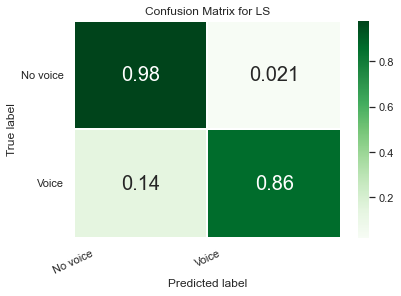

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

matrix = confusion_matrix(pred_bin,y_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(6,4))
sns.set(font_scale=1)
sns.heatmap(matrix, annot=True, annot_kws={'size':20},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['No voice', 'Voice']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for LS')
plt.show()

In [42]:
X_plane_test = X_test_t[y_test==0]
y_plane_test = y_test[y_test==0]

pred = model.predict(X_plane_test)
pred_round = np.around(pred)
pred_bin = pred_round.astype(int)
print('Accuracy for only planes : ',accuracy_score(pred_bin,y_plane_test))

6/6 [==============================] - 0s 30ms/step
Accuracy for only planes :  0.8362573099415205


In [43]:
X_both_test = X_test_t[y_test==1]
y_both_test = y_test[y_test==1]

pred = model.predict(X_both_test)
pred_round = np.around(pred)
pred_bin = pred_round.astype(int)
print('Accuracy for voice + plane : ',accuracy_score(pred_bin,y_both_test))

6/6 [==============================] - 0s 30ms/step
Accuracy for voice + plane :  0.9825581395348837


PARTIE MODELE - CONV2D

In [46]:
freq_range,t_range = X_train[0].shape

input_shape = (freq_range,t_range,1)
inputS = Input(shape=(input_shape),name='main_input')

#modele

y = BatchNormalization()(inputS)
y = Conv2D(16, 1, activation='relu', input_shape=(input_shape))(inputS)
y = MaxPool2D()(y)
# y = Conv2D(32, 1, activation='relu', input_shape=(input_shape))(inputS)
# y = MaxPool2D()(y)
y = Flatten()(y)
y = Dense(16)(y)
y = Dense(1,activation='sigmoid')(y)
# y = Softmax()(y)


model = Model(inputs=[inputS],outputs =y)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

model.fit(X_train,y_train,batch_size=16,epochs=20,verbose=1)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 1025, 100, 1)]    0         
                                                                 
 conv2d (Conv2D)             (None, 1025, 100, 16)     32        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 512, 50, 16)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 409600)            0         
                                                                 
 dense_4 (Dense)             (None, 16)                6553616   
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                             

TEST DU MODELE 

In [12]:
from tensorflow.keras.models import load_model

conv = load_model('Conv2D.h5')
pred = conv.predict(X_test)
pred_round = np.around(pred)
pred_bin = pred_round.astype(int)

print('Accuracy :',accuracy_score(pred_bin,y_test))

Accuracy : 0.7551724137931034


In [47]:
pred = model.predict(X_test)
pred_round = np.around(pred)
pred_bin = pred_round.astype(int)

print('Accuracy :',accuracy_score(pred_bin,y_test))

11/11 [==============================] - 1s 87ms/step
Accuracy : 0.8658892128279884


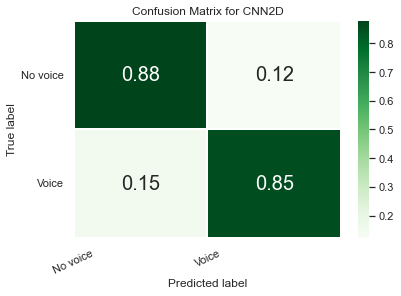

In [49]:
matrix = confusion_matrix(pred_bin,y_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(6,4))
sns.set(font_scale=1)
sns.heatmap(matrix, annot=True, annot_kws={'size':20},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['No voice', 'Voice']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for CNN2D')
plt.show()

In [13]:
X_test.shape

(290, 1025, 100)

In [15]:
X_plane_test = X_test[y_test==0]
y_plane_test = y_test[y_test==0]

pred = model.predict(X_plane_test)
pred_round = np.around(pred)
pred_bin = pred_round.astype(int)
print('Accuracy for only planes : ',accuracy_score(pred_bin,y_plane_test))

Accuracy for only planes :  0.8211920529801324


In [16]:
X_both_test = X_test[y_test==1]
y_both_test = y_test[y_test==1]

pred = model.predict(X_both_test)
pred_round = np.around(pred)
pred_bin = pred_round.astype(int)
print('Accuracy for voice + plane : ',accuracy_score(pred_bin,y_both_test))

Accuracy for voice + plane :  0.8992805755395683


In [17]:
model.save('Conv2D_2.h5')

In [20]:
np.around(model.predict(X_both_test))

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],